<a href="https://colab.research.google.com/github/FaddliLWibowo/Mini_Project-DS-Faddli_Lindra_Wibowo/blob/main/Prediksi_Lalu_Lintas_Pada_Weekend_Jalan_Raya_Pajajaran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Libraries

In [ ]:
#Install lux
!pip install lux-api
# Install Library Neuralprophet
!pip install neuralprophet[live]

In [2]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 
set_random_seed(0)
import matplotlib.dates as mdates
import lux
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
# Import google colab untuk terhubung dengan google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing data

In [4]:
#URL data
df = '/content/drive/MyDrive/00_Kumpulan_Dataset/Bogor/aggregate_median_jams_Kota Bogor.csv'

In [5]:
# Membaca csv
df = pd.read_csv(df)

In [6]:
df.sample(5)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.8/dist-packages/lux/executor/PandasExecutor.py:448: UserWarning:
Lux detects that attributes ['time', 'date'] may be temporal.
To display visualizations for these attributes accurately, please convert temporal attributes to Datetime objects.
For example, you can convert a Year attribute (e.g., 1998, 1971, 1982) using pd.to_datetime by specifying the `format` as '%Y'.

Here is a starter template that you can use for converting the temporal fields:
	df['time'] = pd.to_datetime(df['time'], format='<replace-with-datetime-format>')
	df['date'] = pd.to_datetime(df['date'], format='<replace-with-datetime-format>')

See more at: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
If date is not a temporal attribute, please use override Lux's automatically detected type:
	df.set_data_type({'date':'quantitative'})

Lux detects that attributes ['time', 'date'] may be temporal.
To display visualizations fo

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

## Dataset Overview

In [7]:
#Menampilkan berapa banyak baris dan kolom
df.shape 

(102322, 14)

In [8]:
#Menampilkan daftar kolom, jumlah null, dan tipe data
df.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 102322 entries, 0 to 102321
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 102322 non-null  int64  
 1   time                       102322 non-null  object 
 2   kemendagri_kabupaten_kode  102322 non-null  float64
 3   kemendagri_kabupaten_nama  102322 non-null  object 
 4   street                     100529 non-null  object 
 5   level                      102322 non-null  int64  
 6   median_length              102322 non-null  float64
 7   median_delay               102322 non-null  float64
 8   median_speed_kmh           102322 non-null  float64
 9   total_records              102322 non-null  int64  
 10  id                         102322 non-null  int64  
 11  date                       102322 non-null  object 
 12  median_level               102322 non-null  float64
 13  geometry                   10

In [9]:
#Menampilkan nilai std, min, max dari data
df.describe() 

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

## Data Cleaning

In [10]:
# calculating missingess of entire DF
missingness = df.isnull().sum().sum() / df.count().sum()
print('Overall Missingness of df is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df).head(10)

Overall Missingness of df is: 0.13%


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [11]:
#Hapus baris yang memiliki nilai null
df.dropna(inplace=True)

In [12]:
# calculating missingess of entire DF
missingness = df.isnull().sum().sum() / df.count().sum()
print('Overall Missingness of df is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df).head(10)

Overall Missingness of df is: 0.00%


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [13]:
#Lihat keunikan sebuah data
unique_df = pd.unique(df[['kemendagri_kabupaten_kode', 'kemendagri_kabupaten_nama']].values.ravel())
unique_df

array([32.71, 'KOTA BOGOR'], dtype=object)

In [14]:
#Lihat duplikat data
duplCheck = df.duplicated().sum()
duplCheck
# duplCheck = df.drop_duplicates()

0

In [15]:
#Hapus kolom
df.drop(columns=['Unnamed: 0', 'kemendagri_kabupaten_kode', 'kemendagri_kabupaten_nama', 'median_level', 'total_records'], inplace=True)

In [16]:
#Checking for Outliers
df.skew()

WARNING - (py.warnings._showwarnmsg) - <ipython-input-16-0958adea3d91>:2: FutureWarning:Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.




Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

## Exploratory Data Analysis (EDA)

In [17]:
#Merubah format waktu dari object
df['time'] = df['time'].astype('datetime64[ns]')
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [18]:
# check if the day is weekday or weekend
df["weekend"] = (df["date"].dt.weekday >= 5).astype(int)

In [19]:
df.intent = ["weekend"]
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [20]:
df.intent = ["level"]
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

<Figure size 1152x1152 with 0 Axes>

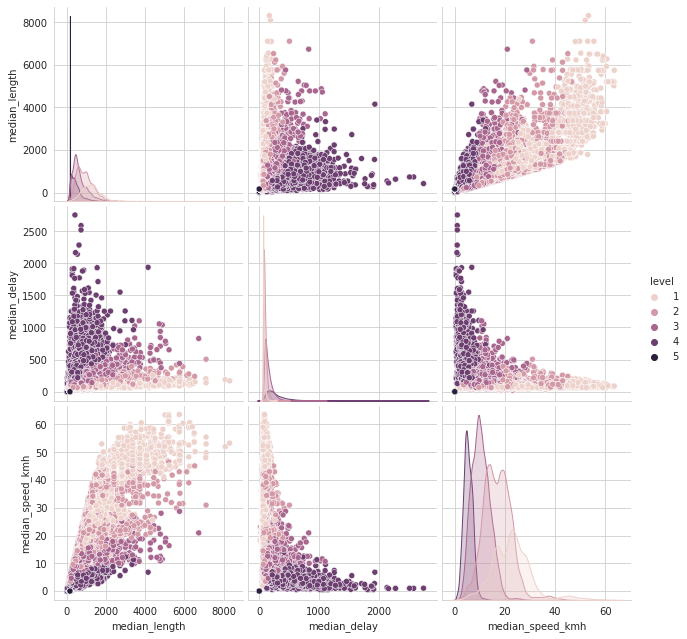

In [21]:
coorDf = plt.figure(figsize=(16,16))
numericalDF = df[['level', 'median_length', 'median_delay', 'median_speed_kmh']].copy()
sns.color_palette("RdPu", 10)
sns.set_style('whitegrid');
sns.pairplot(numericalDF, hue='level', height=3);
plt.show()

<AxesSubplot:xlabel='level', ylabel='median_speed_kmh'>

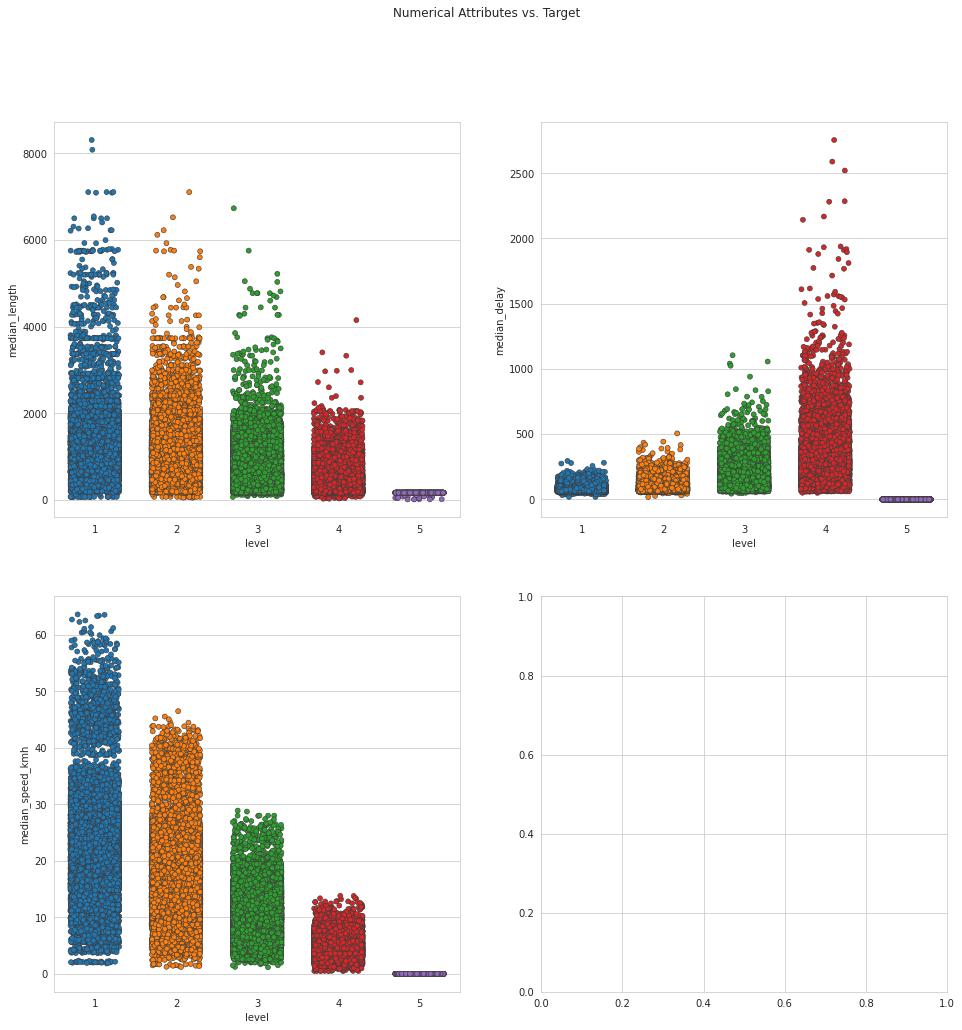

In [22]:
# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(2,2,figsize=(16,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.color_palette("RdBu", 10)
sns.set_style('whitegrid');

# Length vs. 'level'
sns.stripplot(x=df.level, y=df.median_length, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# Delay vs. 'level'
sns.stripplot(x=df.level, y=df.median_delay, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# Speed vs. 'level'
sns.stripplot(x=df.level, y=df.median_speed_kmh, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])

In [23]:
# Length
Q1_Length = df['median_length'].quantile(0.25)
Q3_Length = df['median_length'].quantile(0.75)
IQR_Length = Q3_Length - Q1_Length
under_Length = df['median_length'] < (Q1_Length - 3 * IQR_Length)
upper_Length = df['median_length'] > (Q3_Length + 3 * IQR_Length)
print('Length:', 'lower outliers -', sum(under_Length), ' | upper outliers -', sum(upper_Length))

# Delay
Q1_Delay = df['median_delay'].quantile(0.25)
Q3_Delay = df['median_delay'].quantile(0.75)
IQR_Delay = Q3_Delay - Q1_Delay
under_Delay = df['median_delay'] < (Q1_Delay - 3 * IQR_Delay)
upper_Delay = df['median_delay'] > (Q3_Delay + 3 * IQR_Delay)
print('Delay:', 'lower outliers -', sum(under_Delay), ' | upper outliers -', sum(upper_Delay))

# Speed
Q1_Speed = df['median_speed_kmh'].quantile(0.25)
Q3_Speed = df['median_speed_kmh'].quantile(0.75)
IQR_Speed = Q3_Speed - Q1_Speed
under_Speed = df['median_speed_kmh'] < (Q1_Speed - 3 * IQR_Speed)
upper_Speed = df['median_speed_kmh'] > (Q3_Speed + 3 * IQR_Speed)
print('Speed:', 'lower outliers -', sum(under_Speed), ' | upper outliers -', sum(upper_Speed))

Length: lower outliers - 0  | upper outliers - 543
Delay: lower outliers - 0  | upper outliers - 4042
Speed: lower outliers - 0  | upper outliers - 126


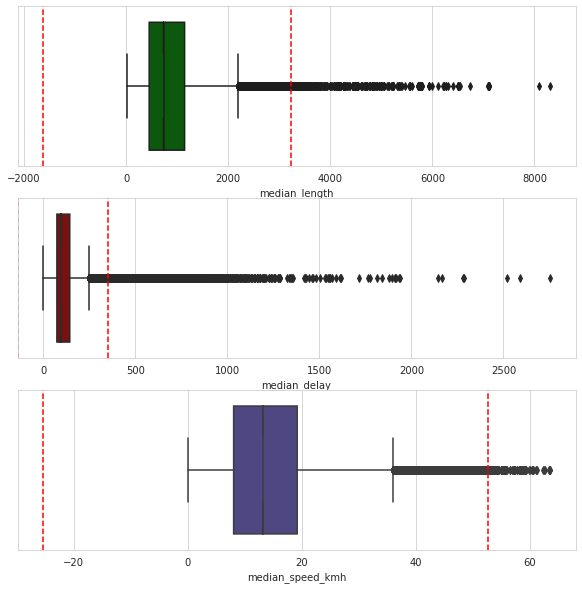

In [24]:
# preparing boxplots
fig, axs= plt.subplots(nrows = 3, figsize=(10,10))


# Length
# df.boxplot(column='median_length', ax=axs[0], vert = False, color='green', notch='True', patch_artist=True)
sns.boxplot(x = df['median_length'], ax=axs[0], color='darkgreen', notch='True')
axs[0].axvline(x=(Q1_Length - 3*IQR_Length), color='r', linestyle='--')
axs[0].axvline(x=(Q3_Length + 3*IQR_Length), color='r', linestyle='--')

# Delay
sns.boxplot(x = df['median_delay'], ax=axs[1], color='darkred', notch='True')
axs[1].axvline(x=(Q1_Delay - 3*IQR_Delay), color='r', linestyle='--')
axs[1].axvline(x=(Q3_Delay + 3*IQR_Delay), color='r', linestyle='--')

# Speed
sns.boxplot(x = df['median_speed_kmh'], ax=axs[2], color='darkslateblue', notch='True')
axs[2].axvline(x=(Q1_Speed - 3*IQR_Speed), color='r', linestyle='--')
axs[2].axvline(x=(Q3_Speed + 3*IQR_Speed), color='r', linestyle='--')

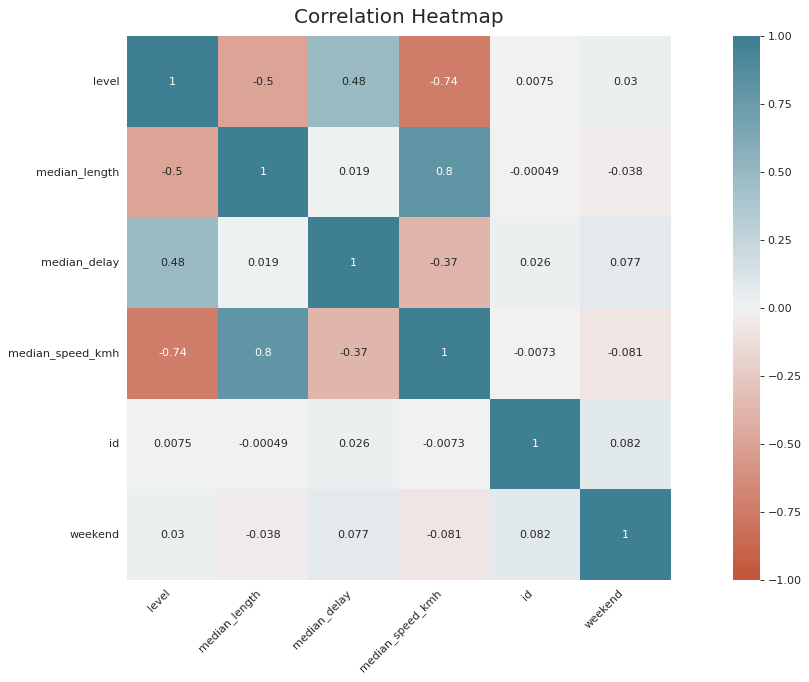

In [25]:
#Menampilkan Correlation Heatmap 
corr = df.corr()
figure_name = plt.figure(figsize=(20, 9), dpi=80)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True
)
ax.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

## Prediksi Kemacetan Pada Weekend di Jalan Raya Pajajaran, Bogor


In [26]:

# Filter Data Jalan dan Weekend
selectDataJam = df[(df.street == 'N9 Jalan Raya Pajajaran') & (df.weekend == 1)]
# selectDataJamMean = selectDataJam.groupby([selectDataJam['time'].dt.date])['median_speed_kmh'].mean()
selectDataJam
# df.loc[(df['first_name'] == 'Bill') | (df['first_name'] == 'Emma'), 'name_match'] = 'Match'  
# df.loc[(df['first_name'] != 'Bill') & (df['first_name'] != 'Emma'), 'name_match'] = 'Mismatch'  

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

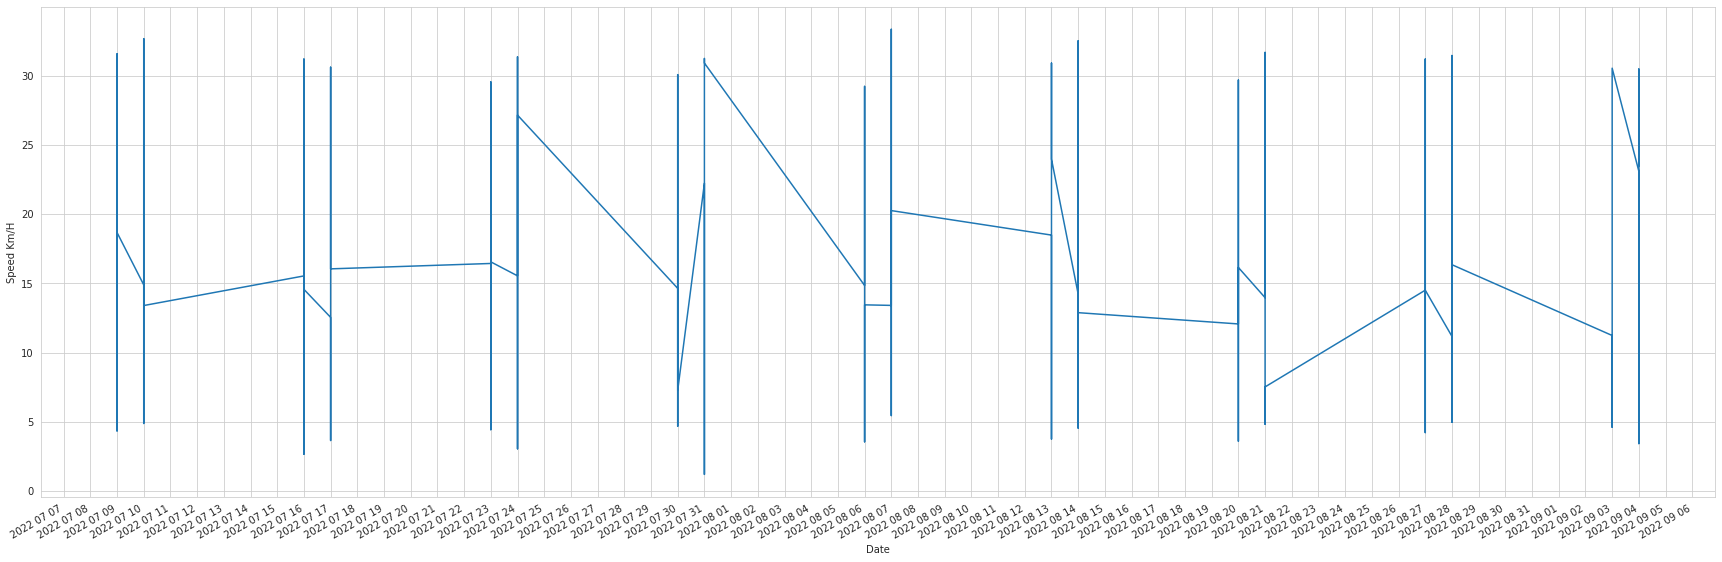

In [27]:
# Membuat grafik berdasarkan tanggal dan speed
plt.figure(figsize=(30,10))
plt.xlabel('Date')
plt.ylabel('Speed Km/H')
plt.plot(selectDataJam['date'], selectDataJam['median_speed_kmh'])
ax = plt.gca()
plt.xticks(rotation = 90)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %m %d'))
plt.gcf().autofmt_xdate()

In [28]:
# Change column time and speed to ds and Y
data = selectDataJam[['time', 'median_speed_kmh']] 
data.columns = ['ds', 'y'] 
data

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [29]:
# Hapus data duplikat
removedf = data.drop_duplicates(['ds'], keep='last')
removedf 

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [46]:
# Membuat Model dan Training data
model = NeuralProphet(daily_seasonality=True,
                      learning_rate=0.01,
                      num_hidden_layers=4,
                      d_hidden=8)
df_train, df_val = model.split_df(removedf, freq='1h', valid_p = 0.2)
metrics = model.fit(removedf, freq='1h', validation_df=df_val, epochs=500, batch_size=512)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 90.582% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 90.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1h
INFO:NP.df_utils:Defined frequency is equal to major frequency - 1h
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 90.582% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 90.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1h
INFO:NP.df_utils:Defined frequency i

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [47]:
# Memprediksi data test
future = model.make_future_dataframe(removedf, periods=24)
forecast = model.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 90.582% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 90.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1h
INFO:NP.df_utils:Defined frequency is equal to major frequency - 1h
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 95.833% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 95.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1h
INFO:NP.df_utils:Defined frequency is equal to major frequency - 1h
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 95.833% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 95.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequenc

Predicting: 1it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


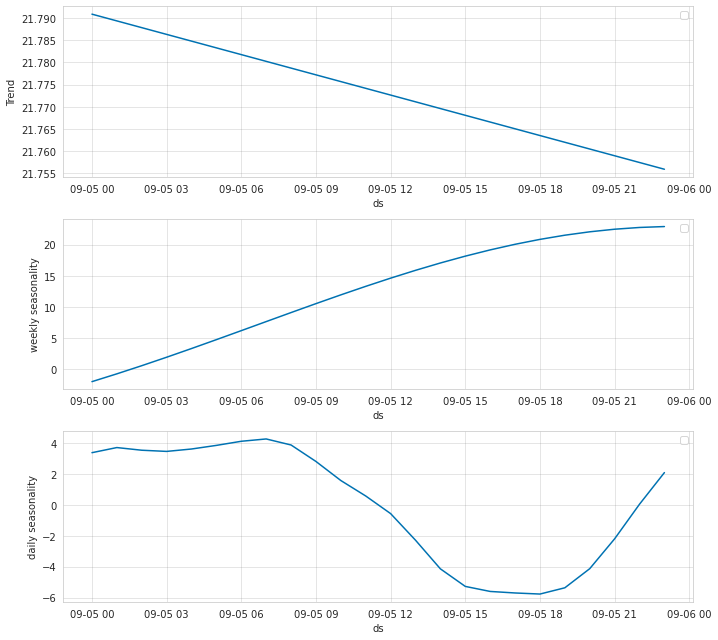

In [48]:
# Menampilkan grafik hasil prediksi
components = model.plot_components(forecast)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 90.582% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 90.582% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1h
INFO:NP.df_utils:Defined frequency is equal to major frequency - 1h
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 90.761% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 90.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1h
INFO:NP.df_utils:Defined frequency is equal to major frequency - 1h
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 90.761% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 90.761% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequenc

Predicting: 1it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


Text(0.5, 1.0, 'Mean Speed di Jalan Raya Pajajaran')

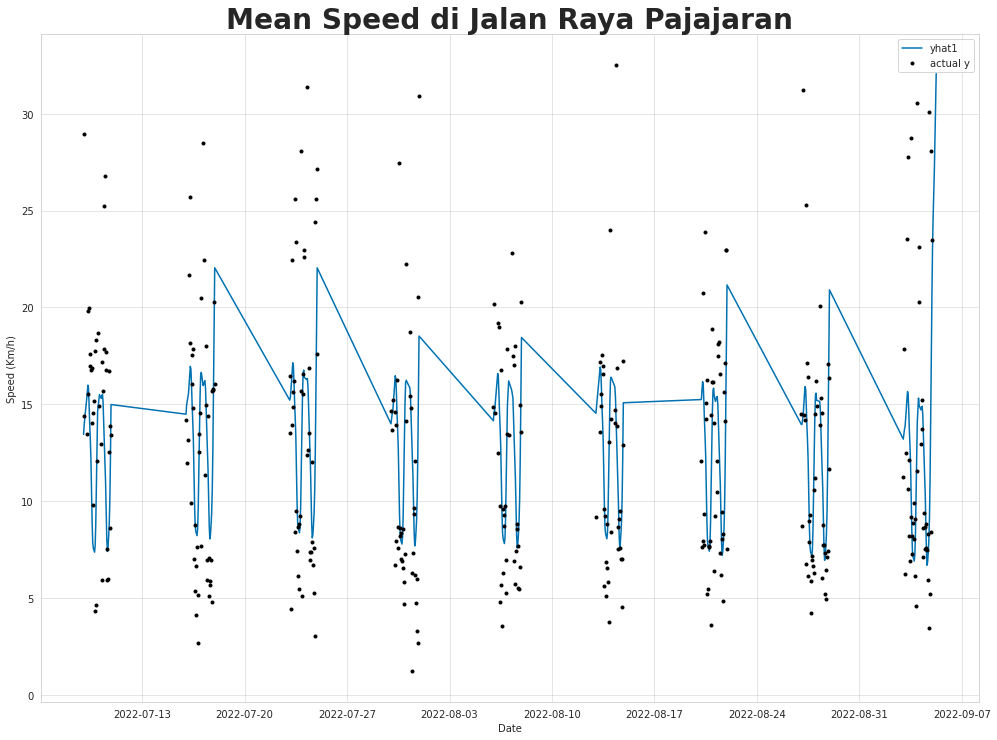

In [49]:
# Prediksi kemacetean dalam seminggu ke depan
# future = model.make_future_dataframe(removedf, periods=365, n_historic_predictions=True) # Dalam Setahun
future = model.make_future_dataframe(removedf, periods=7, n_historic_predictions=True) # Dalam Seminggu
forecast = model.predict(future)
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, xlabel="Date", ylabel="Speed (Km/h)", ax=ax)
ax.set_title("Mean Speed di Jalan Raya Pajajaran", fontsize=28, fontweight="bold")

Text(0.5, 1.0, 'Model Loss (MAE)')

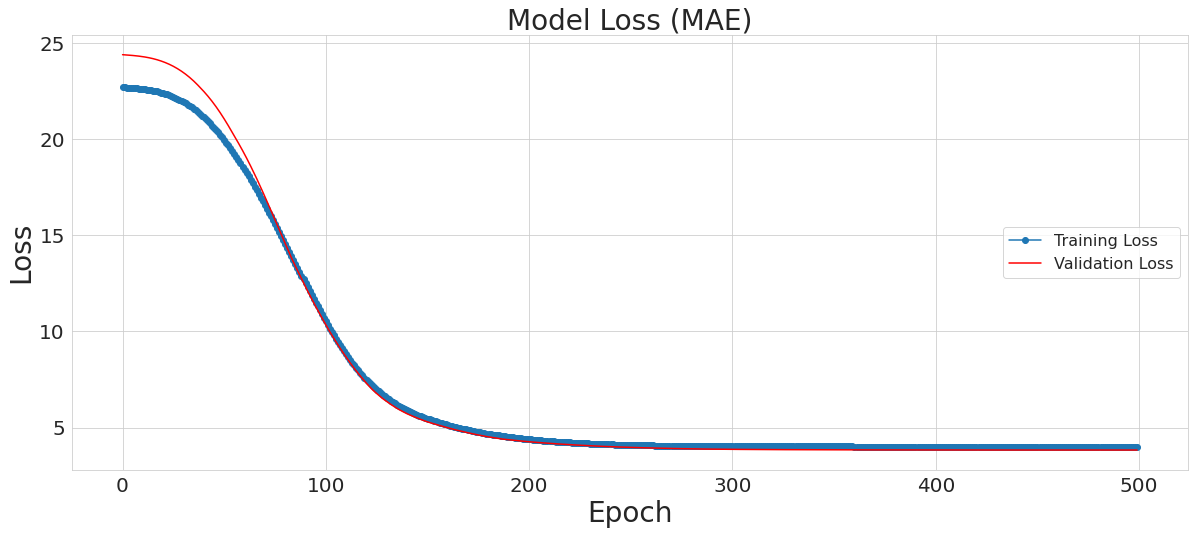

In [50]:
# Membuat grafik train dan val loss
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(metrics["MAE"], '-o', label="Training Loss")  
ax.plot(metrics["MAE_val"], '-r', label="Validation Loss")
ax.legend(loc='center right', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Epoch", fontsize=28)
ax.set_ylabel("Loss", fontsize=28)
ax.set_title("Model Loss (MAE)", fontsize=28)

In [ ]:
selectDataJam['time'] = pd.to_datetime(selectDataJam['time'])
selectDataJam['time'] = selectDataJam['time'].dt.time